In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import random

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import LagGPTEstimator

In [4]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [3]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [38]:
gluonts_ds = [
    get_dataset("airpassengers").train,
    get_dataset("australian_electricity_demand").train,
    get_dataset("car_parts_without_missing").train,
    get_dataset("cif_2016").train,
    get_dataset("covid_deaths").train,
    get_dataset("electricity").train,
    get_dataset("electricity_weekly").train,
    get_dataset("exchange_rate").train,
    get_dataset("fred_md").train,
    get_dataset("hospital").train,
    get_dataset("kaggle_web_traffic_weekly").train,
    get_dataset("kdd_cup_2018_without_missing").train,
    get_dataset("london_smart_meters_without_missing").train,
    get_dataset("nn5_daily_with_missing").train,
    get_dataset("nn5_weekly").train,
    get_dataset("pedestrian_counts").train,
    get_dataset("rideshare_without_missing").train,
    get_dataset("saugeenday").train,
    get_dataset("solar-energy").train,
    get_dataset("solar_10_minutes").train,
    get_dataset("solar_weekly").train,
    get_dataset("taxi_30min").train,
    get_dataset("temperature_rain_without_missing").train,
    get_dataset("tourism_monthly").train,
    get_dataset("traffic").train,
    get_dataset("uber_tlc_daily").train,
    get_dataset("uber_tlc_hourly").train,
    get_dataset("vehicle_trips_without_missing").train,
    get_dataset("weather").train,
    get_dataset("wiki-rolling_nips").train,
    get_dataset("m4_hourly").train,
]
dataset = CombinedDataset(gluonts_ds)

In [3]:
# dataset = get_dataset("electricity").train

In [101]:
estimator = LagGPTEstimator(
    prediction_length=24,
    context_length=1024,
    batch_size=16, # 4
    n_layer=32,
    n_head=32,
    n_embd=512, # 4096
    scaling="std",
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", precision="bf16-mixed"),
)

In [102]:
predictor = estimator.train(
    training_data=dataset, shuffle_buffer_length=30000
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 411 M 
--------------------------------------
411 M     Trainable params
0         Non-trainable params
411 M     Total params
1,644.802 Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictor = estimator.train(                                                                 │
│   2 │   training_data=dataset, shuffle_buffer_length=30000                                       │
│   3 )                                                                                            │
│   4                                                                                              │
│                                                                                                  │
│ /home/kashif/gluon-ts-PR/src/gluonts/torch/model/estimator.py:237 in train                       │
│                                                                                                  │
│   234 │   │   ckpt_path: Optional[str] = None,                                                   │
│   235 │   │   **kwargs,                                                                          │
│   236 │   ) -> PyTorchPredictor:                                                                 │
│ ❱ 237 │   │   return self.train_model(                                                           │
│   238 │   │   │   training_data,                                                                 │
│   239 │   │   │   validation_data,                                                               │
│   240 │   │   │   shuffle_buffer_length=shuffle_buffer_length,                                   │
│                                                                                                  │
│ /home/kashif/gluon-ts-PR/src/gluonts/torch/model/estimator.py:205 in train_model                 │
│                                                                                                  │
│   202 │   │   trainer_kwargs = {**self.trainer_kwargs, "callbacks": callbacks}                   │
│   203 │   │   trainer = pl.Trainer(**trainer_kwargs)                                             │
│   204 │   │                                                                                      │
│ ❱ 205 │   │   trainer.fit(                                                                       │
│   206 │   │   │   model=training_network,                                                        │
│   207 │   │   │   train_dataloaders=training_data_loader,                                        │
│   208 │   │   │   val_dataloaders=validation_data_loader,                                        │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:520  │
│ in fit                                                                                           │
│                                                                                                  │
│    517 │   │   """                                                                               │
│    518 │   │   model = _maybe_unwrap_optimized(model)                                            │
│    519 │   │   self.strategy._lightning_module = model                                           │
│ ❱  520 │   │   call._call_and_handle_interrupt(                                                  │
│    521 │   │   │   self, self._fit_impl, model, train_dataloaders, val_dataloaders, datamodule,  │
│    522 │   │   )                                                                                 │
│    523                                                                                           │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/pyto

In [86]:
test_dataset = get_dataset("m4_weekly").test

In [87]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [88]:
forecasts = list(forecast_it)

In [89]:
tss = list(ts_it)

In [90]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)


Running evaluation: 100%|███████████████████████████████████████████████████████████████| 359/359 [00:00<00:00, 5444.59it/s]


In [91]:
agg_metrics

{'MSE': 2357618.9681848157,
 'abs_error': 7469511.265991211,
 'abs_target_sum': 46388328.9987793,
 'abs_target_mean': 5383.975046283576,
 'seasonal_error': 220.28471316811846,
 'MASE': 11.913167836678022,
 'MAPE': 0.2340722073668557,
 'sMAPE': 0.19111300486389862,
 'MSIS': 277.54289854170173,
 'QuantileLoss[0.1]': 6265768.242858887,
 'Coverage[0.1]': 0.4792246982358403,
 'QuantileLoss[0.2]': 7021478.36760254,
 'Coverage[0.2]': 0.5323816155988857,
 'QuantileLoss[0.3]': 7374819.191838073,
 'Coverage[0.3]': 0.5696378830083565,
 'QuantileLoss[0.4]': 7507416.608770752,
 'Coverage[0.4]': 0.6010909935004641,
 'QuantileLoss[0.5]': 7469511.247512817,
 'Coverage[0.5]': 0.6295264623955432,
 'QuantileLoss[0.6]': 7272851.331396485,
 'Coverage[0.6]': 0.65169452181987,
 'QuantileLoss[0.7]': 6922245.55185852,
 'Coverage[0.7]': 0.6753714020427112,
 'QuantileLoss[0.8]': 6369466.0074157715,
 'Coverage[0.8]': 0.7039229340761375,
 'QuantileLoss[0.9]': 5494781.731820678,
 'Coverage[0.9]': 0.7416434540389972

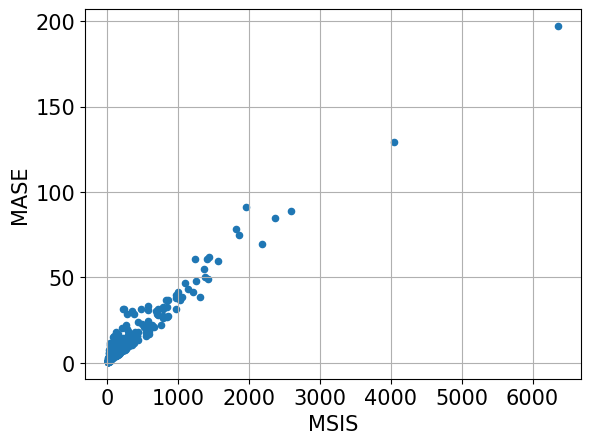

In [92]:
ts_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

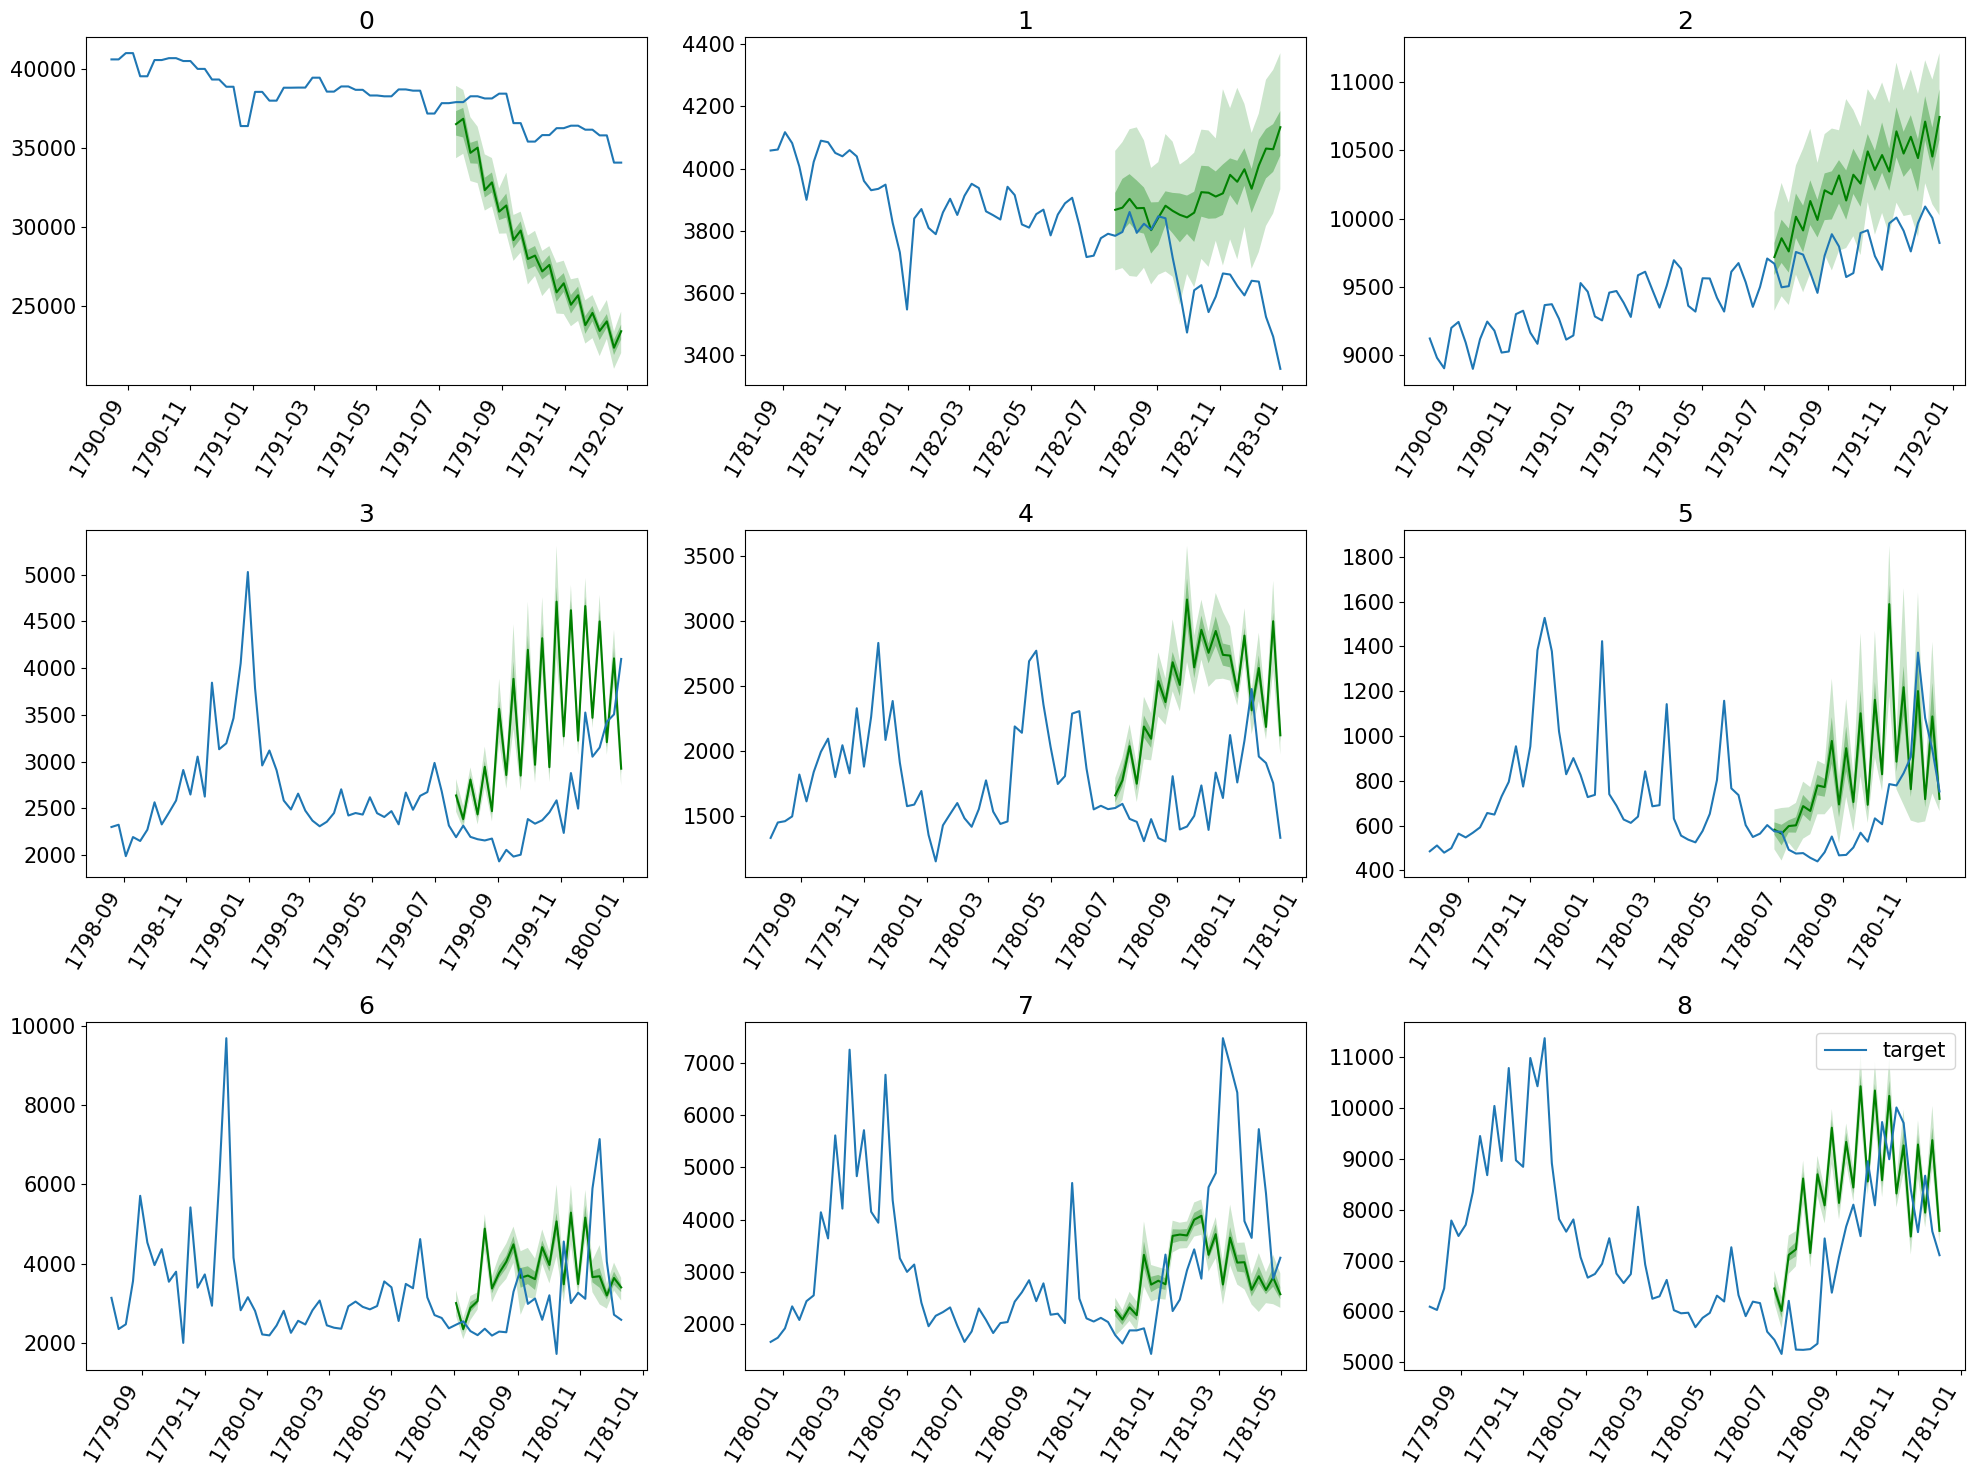

In [93]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

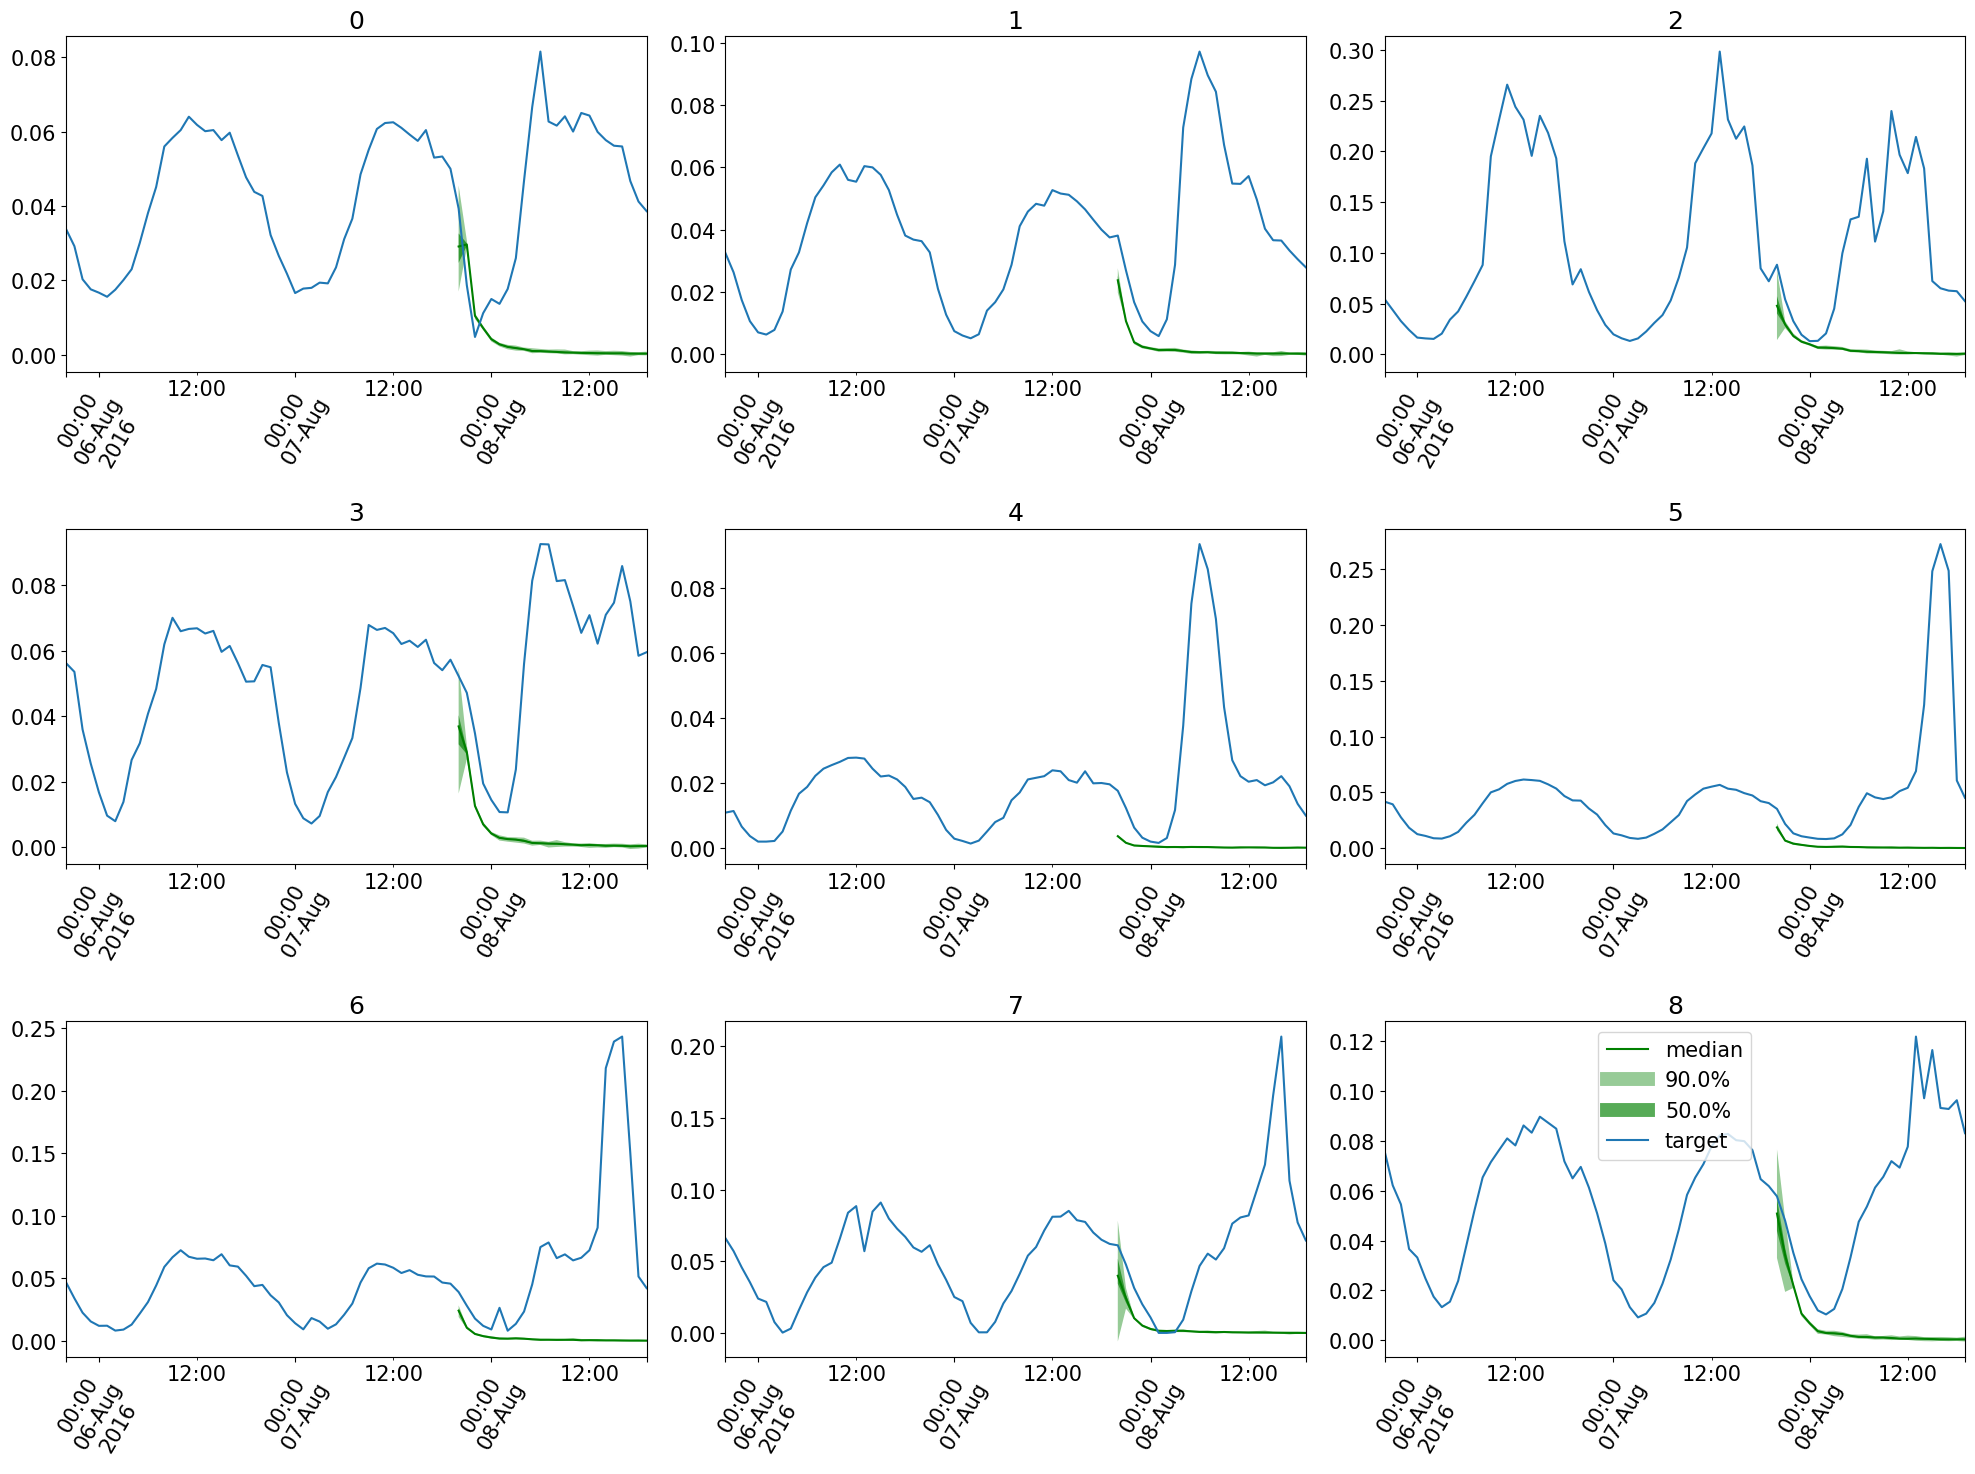

In [68]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [10]:
# beam
agg_metrics

{'MSE': 2353700.5849478617,
 'abs_error': 10347671.897188187,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8922449918745382,
 'MAPE': 0.11220455807131616,
 'sMAPE': 0.1165269710200355,
 'MSIS': 12.069460309886567,
 'QuantileLoss[0.1]': 4623474.5003027115,
 'Coverage[0.1]': 0.15873015873015875,
 'QuantileLoss[0.2]': 6818143.679625946,
 'Coverage[0.2]': 0.23221703011422637,
 'QuantileLoss[0.3]': 8406636.595204707,
 'Coverage[0.3]': 0.29175938288087816,
 'QuantileLoss[0.4]': 9575201.4348929,
 'Coverage[0.4]': 0.34625797359442223,
 'QuantileLoss[0.5]': 10347671.921518601,
 'Coverage[0.5]': 0.4009790832220739,
 'QuantileLoss[0.6]': 10781971.85629762,
 'Coverage[0.6]': 0.45202863076694855,
 'QuantileLoss[0.7]': 10792582.533077706,
 'Coverage[0.7]': 0.5083815457647234,
 'QuantileLoss[0.8]': 10251792.43568935,
 'Coverage[0.8]': 0.579105473965287,
 'QuantileLoss[0.9]': 8707283.513710178,
 'Coverage[0.9]': 0.669707758492

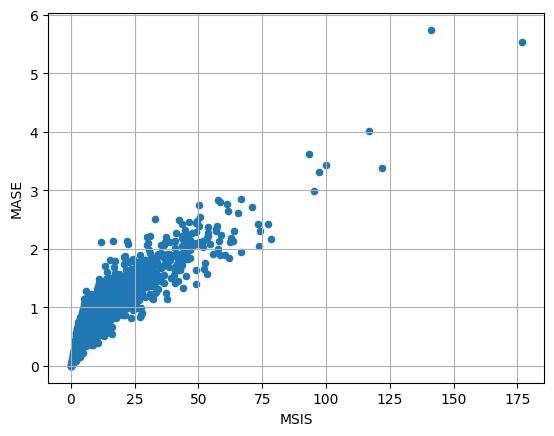

In [11]:
ts_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

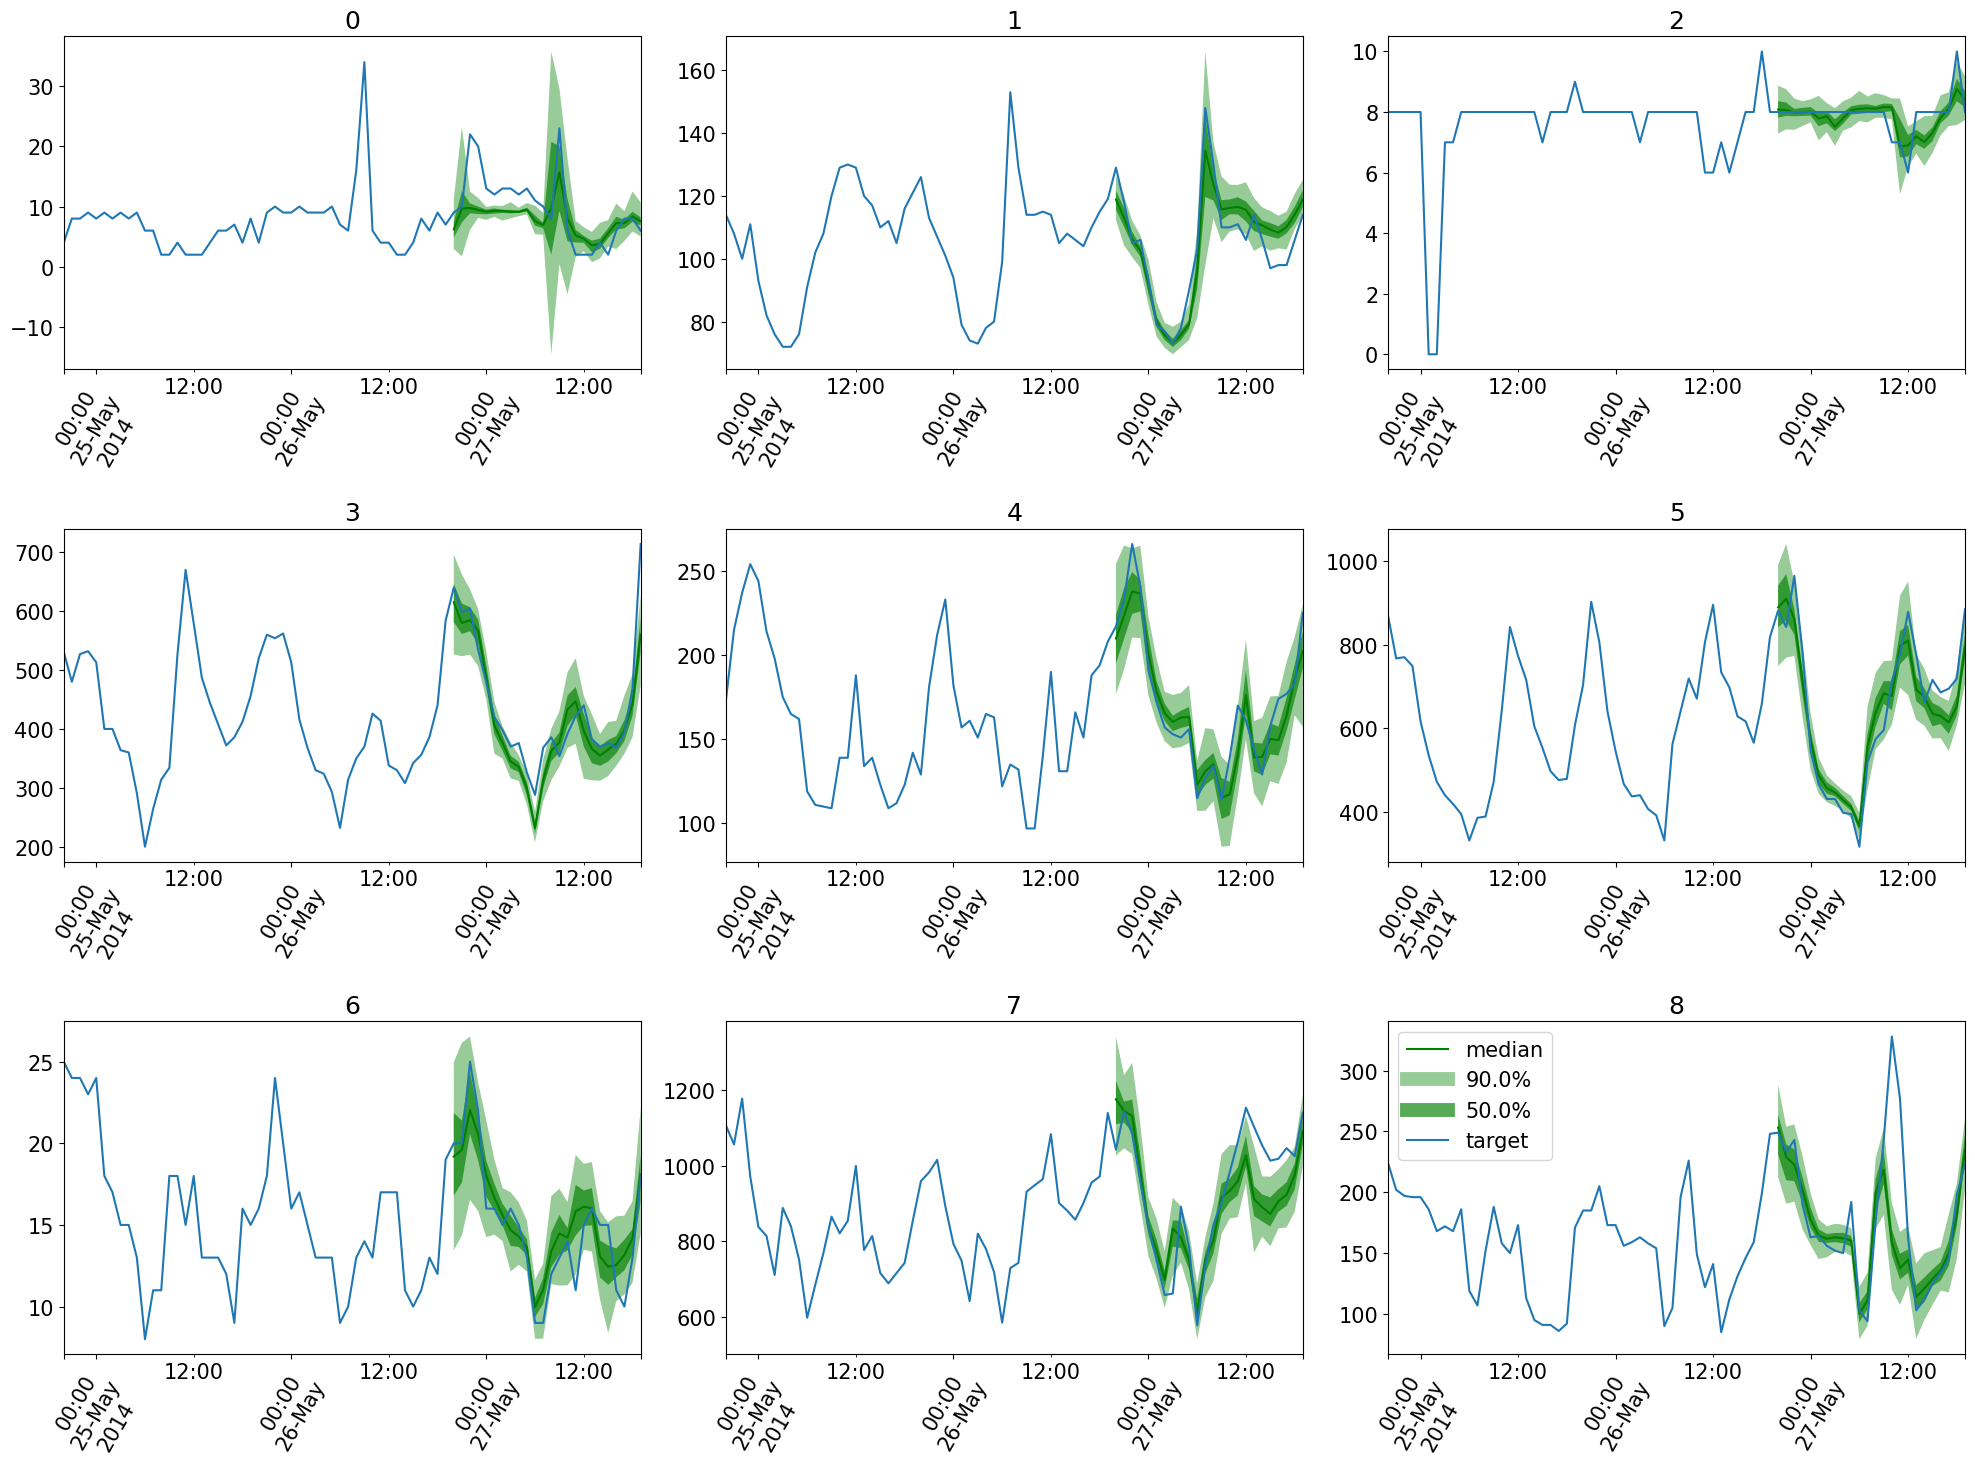

In [12]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * dataset.metadata.prediction_length:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()